# TABLE OF CONTENTS

- [OBTAIN](#OBTAIN) 
- [SCRUB](#SCRUB) 
- [EXPLORE](#EXPLORE) 
- [MODEL](#MODEL) 
- [iNTERPRET](#iNTERPRET) 

### [CONCLUSIONS & RECOMMENDATIONS](#CONCLUSIONS-&-RECOMMENDATIONS)
___

In [1]:
# PyPi package for cohort
# !pip install -U fsds_100719 # comment out after install so it won't run again

# OBTAIN

In [2]:
!pip install -U fsds_100719
import IPython.display as disp
disp.clear_output()

In [3]:
# Shortcut import of 
# import pandas as pd, numpy as np, etc...
import fsds_100719 as fs
from fsds_100719.imports import *

Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [4]:
%ls

CONTRIBUTING.md             draft_files/
LICENSE.md                  kc_house_data.csv
README.md                   module1_project_rubric.pdf
awesome.gif                 presentation.pdf
column_names.md             student.ipynb


In [5]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Define Functions

In [6]:
# Check columns returns the datatype, null values and unique values of input series 
def check_column(series_feature, series_target=None, max_unique=10,
                 nbins = None):
    """Takes a series from a dataframe (df[col]), 
    reports back info on unique values, nulls, .describe() stats.
    
    
    Args:
        series (series (DataFrame column)): column to report    
    """
    dashes = '---'*25
    series=series_feature
    
    
    print(dashes)
    
    print(f"series dtype is {series.dtype}\n")
    print(f'- Unique Values for {series.name}')
    display(series.value_counts(bins = nbins))#[0:max_unique])#[:max_unique])
    
    print('n- Null Values ')
    nulls = series.isna().sum()
    print(nulls)
    
    print('\n\tDescribe')
    print(series.describe())
    
    if series.dtype != 'object':
        fig, axes = plt.subplots(figsize=(15, 5), ncols=2, nrows=1)
        axes[0].set_title(f"Showing {series_target.name}")
        axes[0].set_title(series.name)
        sns.distplot(series, ax = axes[0])
    else:
        print(f"{series.name} is a string column and cannot be plotted")

    if series_target is not None: 
        axes[1].set_title(f"{series_feature.name} vs {series_target.name} (in thousands)")
        sns.scatterplot(series_feature, series_target, ax = axes[1])

In [7]:
def check_outliers(feature, std_multiplier = 3) :
    """ Takes a series or a dataframe as a feaature and provides feedback on 
    the following:
    
    The feature's mean value
    The value of a given standard deviation
    A count of records above that value
    The percent of total records above that value.
    
    Parameters
    ----------
    feature : series or dataframe
    std_multiplier : integer, default 3, used to by specify how my times 
    to multiply the standard deviation to reach the final figure.
    
    The purpose of this function is to provide insight about a feature's number
    of records beyond a certain point relative to standard deviation before
    invoking function cut_outliers.
    """
    feature_std_xx = round(feature.mean() + (feature.std()*std_multiplier), 2)
    feature_cut = df.loc[df[feature.name] > feature_std_xx][feature.name]
    outside_std_count = feature_cut.count()
    pct_outside_std = round(outside_std_count / feature.count(), 2)
    print(f'Mean feature value is: {round(feature.mean(),2)}')
    print(f'{std_multiplier}x standard deviation cutoff: {feature_std_xx}')
    print(f'Records above {std_multiplier}x standard deviation: {outside_std_count}')
    print(f'Percent of records above {std_multiplier}x standard deviation: {pct_outside_std}')
    
    feature_std_lxx = round(feature.mean() - (feature.std()*std_multiplier), 2)
    feature_cutl = df.loc[df[feature.name] < feature_std_lxx][feature.name]
    outside_std_countl = feature_cutl.count()
    pct_outside_stdl = round(outside_std_countl / feature.count(), 2)
    print(f'{std_multiplier}x standard deviation lower cutoff: {feature_std_lxx}')
    print(f'Records below {std_multiplier}x standard deviation: {outside_std_countl}')
    print(f'Percent of records above {std_multiplier}x standard deviation: {pct_outside_stdl}')

In [8]:
def cut_upper_outliers(feature, std_multiplier = 3):
    """Takes a series or dataframe and returns a series with all records cut
    out above the standard deviation multiplied as specified in argument.
    
    Parameters
    ----------
    feature : series or dataframe
    std_multiplier : integer, default 3, used to by specify how my times 
    to multiply the standard deviation to reach the final figure.
    """  
    
    feature_std_xx = round(feature.mean() + (feature.std()*std_multiplier), 2)
#     return df.loc[df[feature.name] < feature_std_xx][feature.name]
    return df.loc[df[feature.name] < feature_std_xx]

In [9]:
def cut_lower_outliers(feature, std_multiplier = 3):
    """Takes a series or dataframe and returns a series with all records cut
    out above the standard deviation multiplied as specified in argument.
    
    Parameters
    ----------
    feature : series or dataframe
    std_multiplier : integer, default 3, used to by specify how my times 
    to multiply the standard deviation to reach the final figure.
    """  
    
#     feature_std_xx = round(feature.mean() + (feature.std()*std_multiplier), 2)
    feature_std_lxx = round(feature.mean() - (feature.std()*std_multiplier), 2)
    return df.loc[df[feature.name] > feature_std_lxx][feature.name]

# SCRUB

In [10]:
# Ignore pink warnings 
import warnings
warnings.filterwarnings('ignore')

# Allow for a large # of columns
pd.set_option('display.max_columns',0)
# pd.set_option('display.max_rows','')

## Information Overview

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [12]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## Cleaning Data

In [13]:
# scaling price to make it more readable.
df['price'] = df['price'] / 1000

In [14]:
# Starting to get rid of unnecessary columns and data.
df = df.drop(['id'], axis = 1)

In [15]:
#Proceeding to find null values and figure out 
# what to do with those.

In [16]:
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [17]:
# View is a difficult category to desipher anyway, so I'm not going to worry about
# the null values there since I won't be using that data.

In [18]:
df = df.drop(['view'], axis = 1)

In [19]:
# Beyond that, it looks like the only offenders are waterfrom and yr_renovated. 
# In both cases, it actually makes sense not to have values in the records,
# since the question would not apply to most houses. Yr renovated is boyond the
# scope of the questions I'll be asking, so I'll drop that one.

In [20]:
df = df.drop(['yr_renovated'], axis = 1)

In [21]:
# For waterfront, I'll replace those null values with zeros. It's a bit of a 
# stretch of an assumption to assume all or most of the null values are non-
# waterfront, but it's such an important variable for home value that I feel 
# compelled to keep it.

In [22]:
df['waterfront'] = df['waterfront'].fillna(0)

In [23]:
df.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Checking for duplicates:

In [24]:
df[df.duplicated()]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15


Looks fine!

# EXPLORE

---------------------------------------------------------------------------
series dtype is int64

- Unique Values for sqft_living


(1687.0, 3004.0]      10166
(356.829, 1687.0]      8354
(3004.0, 4321.0]       2580
(4321.0, 5638.0]        395
(5638.0, 6955.0]         72
(6955.0, 8272.0]         23
(9589.0, 10906.0]         3
(8272.0, 9589.0]          2
(12223.0, 13540.0]        1
(10906.0, 12223.0]        1
Name: sqft_living, dtype: int64

n- Null Values 
0

	Describe
count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64


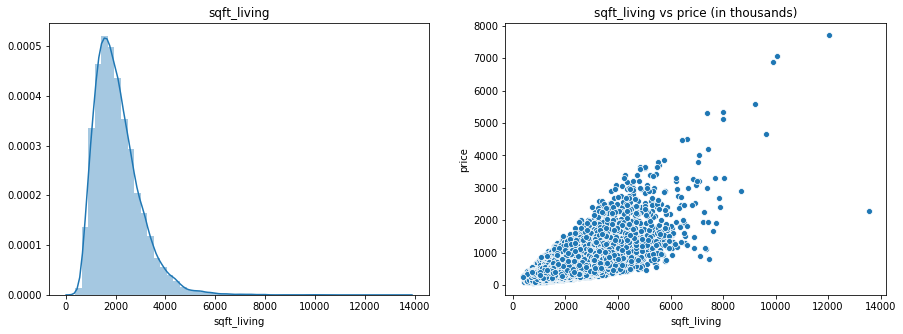

In [25]:
#Check the most obvious factor.

check_column(df['sqft_living'], df['price'], nbins = 10)

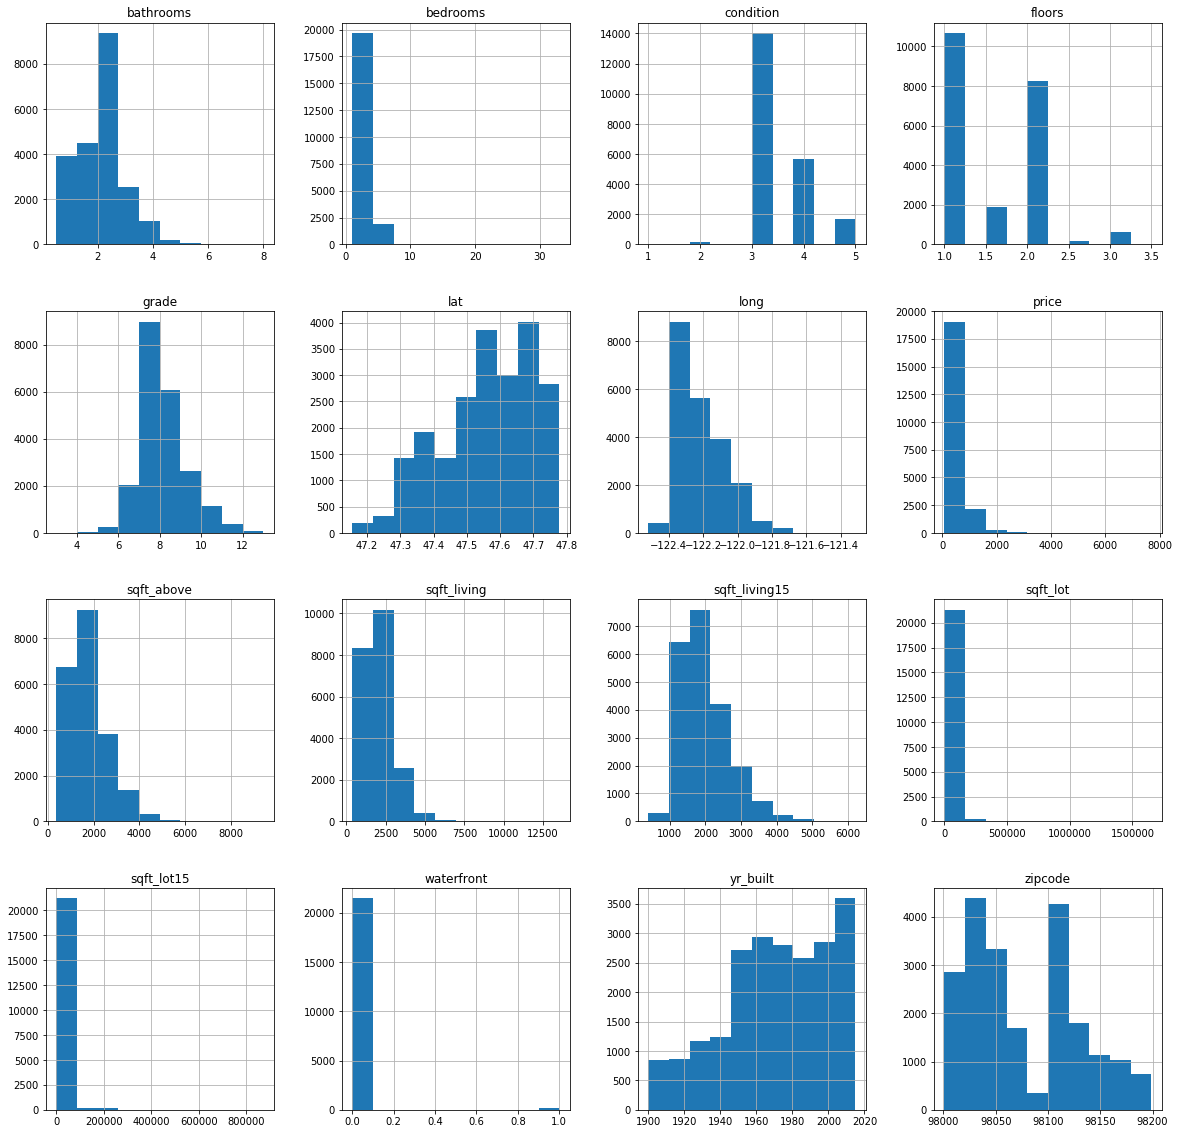

In [26]:
df.hist(figsize=(20,20));

In [27]:
# pd.plotting.scatter_matrix(df, figsize=(20,20));
# Commenting out to save computing time during re-runs.

## Handle outliers

There is a wide variance among houses in the very highest reaches of the price range throwing things into chaos, and their small numbers make them good candidates for being cut.

All homes above roughly 1.6M make up only 2% of the total set. And  yet 
the mean price is only 540K. I'll get rid rid of that far-end 2%. 

I mean, one of those houses could have belonged to Kurt Cobain, throwing
off the whole curve.

First, price:

In [28]:
df.price.describe()

count    21597.000000
mean       540.296574
std        367.368140
min         78.000000
25%        322.000000
50%        450.000000
75%        645.000000
max       7700.000000
Name: price, dtype: float64

In [29]:
check_outliers(df.price, 3)

Mean feature value is: 540.3
3x standard deviation cutoff: 1642.4
Records above 3x standard deviation: 406
Percent of records above 3x standard deviation: 0.02
3x standard deviation lower cutoff: -561.81
Records below 3x standard deviation: 0
Percent of records above 3x standard deviation: 0.0


In [30]:
df = cut_upper_outliers(df.price, 3)

In [31]:
df.price.describe()

count    21191.000000
mean       507.010292
std        259.462210
min         78.000000
25%        320.000000
50%        447.000000
75%        627.650000
max       1640.000000
Name: price, dtype: float64

Next, bedrooms:

Next, sqft_living:

In [32]:
df.sqft_living.describe()

count    21191.000000
mean      2032.486103
std        836.738586
min        370.000000
25%       1410.000000
50%       1890.000000
75%       2500.000000
max       7480.000000
Name: sqft_living, dtype: float64

In [33]:
check_outliers(df.sqft_living)

Mean feature value is: 2032.49
3x standard deviation cutoff: 4542.7
Records above 3x standard deviation: 194
Percent of records above 3x standard deviation: 0.01
3x standard deviation lower cutoff: -477.73
Records below 3x standard deviation: 0
Percent of records above 3x standard deviation: 0.0


In [34]:
df = cut_upper_outliers(df.sqft_living)

In [35]:
df.sqft_living.describe()

count    20997.000000
mean      2003.336715
std        781.184688
min        370.000000
25%       1410.000000
50%       1880.000000
75%       2483.000000
max       4540.000000
Name: sqft_living, dtype: float64

Next, latitude and longitude:

In [36]:
check_outliers(df.lat, 3)

Mean feature value is: 47.56
3x standard deviation cutoff: 47.98
Records above 3x standard deviation: 0
Percent of records above 3x standard deviation: 0.0
3x standard deviation lower cutoff: 47.14
Records below 3x standard deviation: 0
Percent of records above 3x standard deviation: 0.0


In [37]:
check_outliers(df.long, 3)

Mean feature value is: -122.21
3x standard deviation cutoff: -121.79
Records above 3x standard deviation: 227
Percent of records above 3x standard deviation: 0.01
3x standard deviation lower cutoff: -122.64
Records below 3x standard deviation: 0
Percent of records above 3x standard deviation: 0.0


In [38]:
df = cut_upper_outliers(df.long, 3)

In [39]:
check_outliers(df.long, 3)

Mean feature value is: -122.22
3x standard deviation cutoff: -121.82
Records above 3x standard deviation: 22
Percent of records above 3x standard deviation: 0.0
3x standard deviation lower cutoff: -122.62
Records below 3x standard deviation: 0
Percent of records above 3x standard deviation: 0.0


I want to have a closer look at bedrooms

In [40]:
df['bedrooms'].value_counts()

3     9599
4     6536
2     2732
5     1429
6      236
1      192
7       28
8        9
9        5
10       2
11       1
33       1
Name: bedrooms, dtype: int64

---------------------------------------------------------------------------
series dtype is int64

- Unique Values for bedrooms


3     9599
4     6536
2     2732
5     1429
6      236
1      192
7       28
8        9
9        5
10       2
11       1
33       1
Name: bedrooms, dtype: int64

n- Null Values 
0

	Describe
count    20770.000000
mean         3.347857
std          0.912085
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64


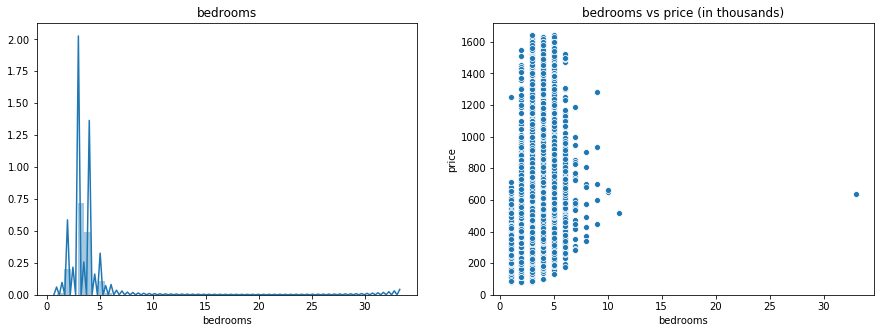

In [41]:
check_column(df.bedrooms, df.price)

In [42]:
check_outliers(df.bedrooms)

Mean feature value is: 3.35
3x standard deviation cutoff: 6.08
Records above 3x standard deviation: 46
Percent of records above 3x standard deviation: 0.0
3x standard deviation lower cutoff: 0.61
Records below 3x standard deviation: 0
Percent of records above 3x standard deviation: 0.0


There's actually something interesting going on here, so I'm not going to remove all >3x std outliers. Just that one at 33 bedrooms that is clearly a typo.

In [43]:
df = df.loc[df['bedrooms'] < 33]

In [44]:
df.loc[df['bedrooms'] >= 33]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15


---------------------------------------------------------------------------
series dtype is int64

- Unique Values for bedrooms


3     9599
4     6536
2     2732
5     1429
6      236
1      192
7       28
8        9
9        5
10       2
11       1
Name: bedrooms, dtype: int64

n- Null Values 
0

	Describe
count    20769.000000
mean         3.346430
std          0.888595
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64


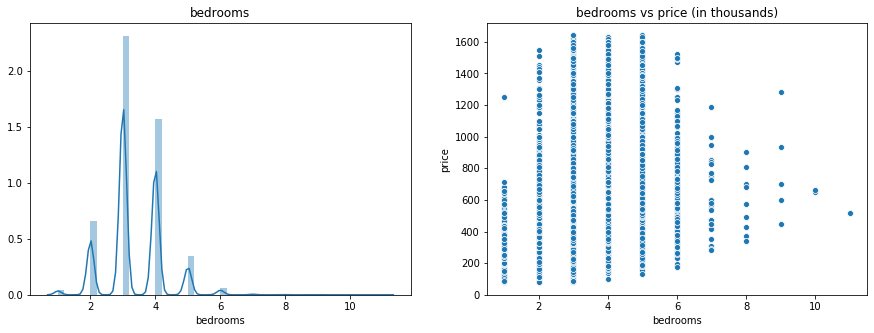

In [45]:
check_column(df.bedrooms, df.price)

I'm not going to use the 'bedrooms' feature in my model, because there are problems
with its linearity. But those same problems will be useful in my conclusions and
recommendations later on.

Moving forward: Re-creating some of the histograms of the features I've adjusted

In [46]:
temp_df = df[['price', 'sqft_living', 'bedrooms', 'lat', 'long']]

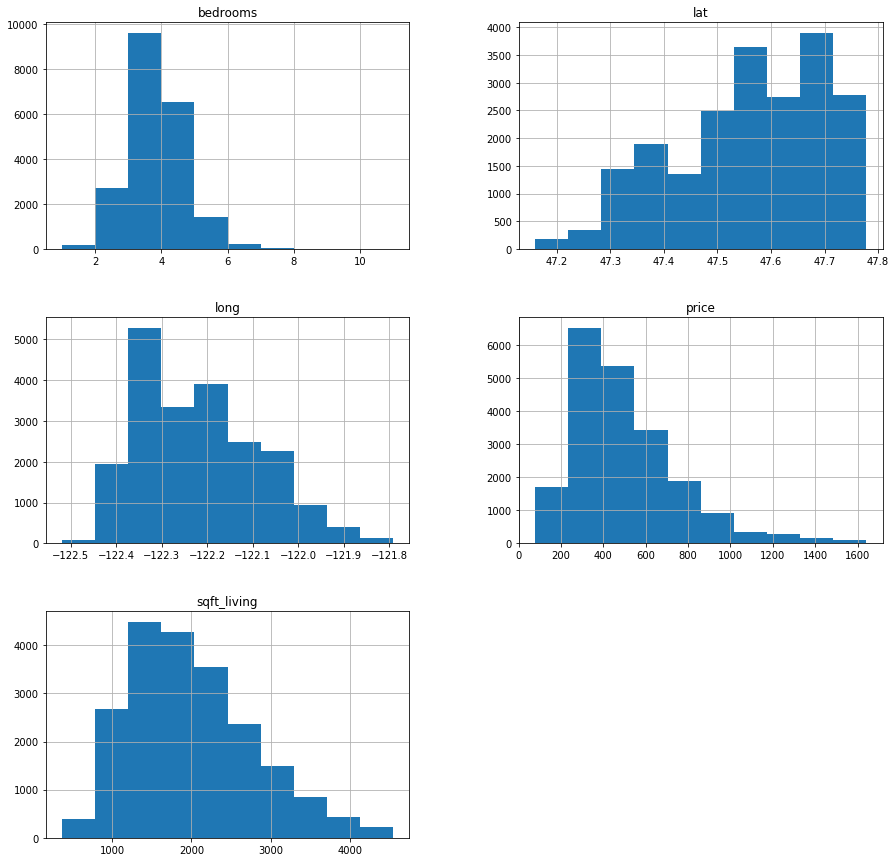

In [47]:
temp_df.hist(figsize = (15, 15))
plt.show()

Those look tons better.

## Handle multicollinearity

In [48]:
abs(df.corr()>.75)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
sqft_above,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False


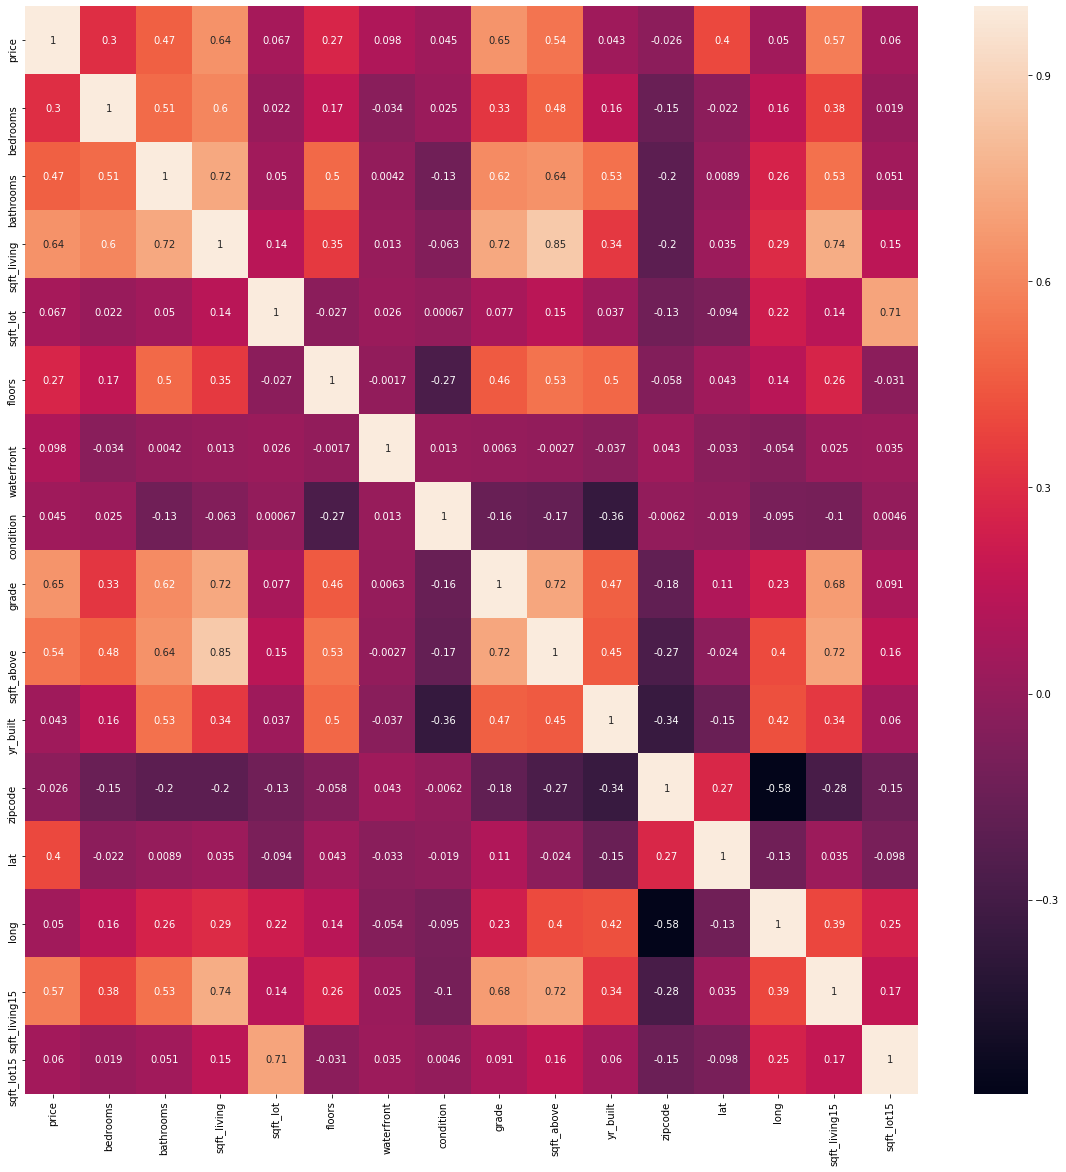

In [49]:
plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), annot = True)

In [50]:
# Based on the above charts showing correlations, I will remove the following variables
# with correlaations over .75 to avoid multicolinearity convlicts:
# bathrooms, sqft_above, grade, sqft_living15, which all correlate with sqft_living.
# The presumption is that the square footage of living space is the driving factor behind the 
# other features, and those factors will only cause correlation conflicts if used in any meaningful analyses.

In [51]:
# Note that I wound up bringing grade and bathrooms back into some of the models
# after a few run-throughs to play with things a bit more.

df = df.drop(['sqft_above', 'sqft_living15'], axis = 1)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_basement,yr_built,zipcode,lat,long,sqft_lot15
0,10/13/2014,221.9,3,1.00,1180,5650,1.0,0.0,3,7,0.0,1955,98178,47.5112,-122.257,5650
1,12/9/2014,538.0,3,2.25,2570,7242,2.0,0.0,3,7,400.0,1951,98125,47.7210,-122.319,7639
2,2/25/2015,180.0,2,1.00,770,10000,1.0,0.0,3,6,0.0,1933,98028,47.7379,-122.233,8062
3,12/9/2014,604.0,4,3.00,1960,5000,1.0,0.0,5,7,910.0,1965,98136,47.5208,-122.393,5000
4,2/18/2015,510.0,3,2.00,1680,8080,1.0,0.0,3,8,0.0,1987,98074,47.6168,-122.045,7503


---------------------------------------------------------------------------
series dtype is float64

- Unique Values for long


(-122.374, -122.228]    8616
(-122.228, -122.083]    6406
(-122.083, -121.937]    3194
(-122.521, -122.374]    2034
(-121.937, -121.792]     519
Name: long, dtype: int64

n- Null Values 
0

	Describe
count    20769.000000
mean      -122.220039
std          0.131894
min       -122.519000
25%       -122.331000
50%       -122.237000
75%       -122.129000
max       -121.792000
Name: long, dtype: float64


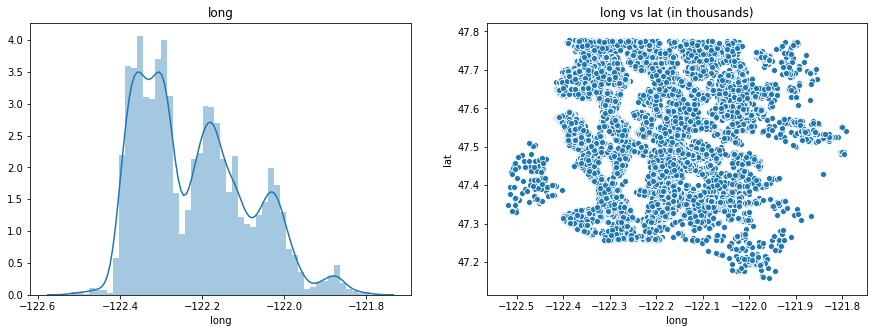

In [52]:
check_column(df['long'], df['lat'], nbins = 5)

Lat and long together basically create a map of Seattle and the surrounding areas. The histogram even
seems to represent the density of the Seattle area and the dropoff to the east. So latitude and longitude could
be indicators of where these locations fall within that area.

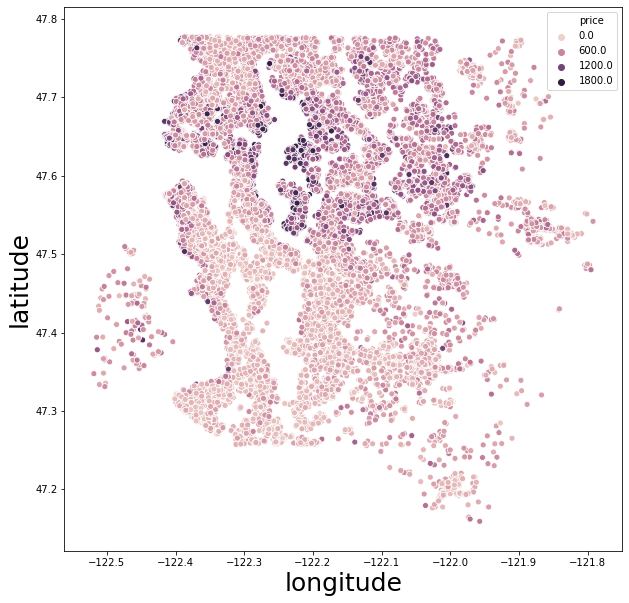

In [53]:
plt.figure(figsize = (10,10))
sns.scatterplot(df.long, df.lat, df.price)
plt.xlabel('longitude', fontsize = 25)
plt.ylabel('latitude', fontsize = 25)
plt.show()

# axes[1].set_title(f"{series_feature.name} vs {series_target.name} (in thousands)")
# sns.scatterplot(series_feature, series_target, ax = axes[1])

I'm a little worried about this because it doesn't look terribly linear. But we'll see how it works out.

---------------------------------------------------------------------------
series dtype is int64

- Unique Values for yr_built


(2005.8, 2010.4]      1520
(2001.2, 2005.8]      1448
(1964.4, 1969.0]      1414
(1973.6, 1978.2]      1364
(1950.6, 1955.2]      1223
(1987.4, 1992.0]      1221
(1959.8, 1964.4]      1192
(1982.8, 1987.4]      1138
(1996.6, 2001.2]      1105
(2010.4, 2015.0]      1032
(1955.2, 1959.8]       941
(1946.0, 1950.6]       923
(1978.2, 1982.8]       849
(1992.0, 1996.6]       760
(1941.4, 1946.0]       747
(1923.0, 1927.6]       583
(1936.8, 1941.4]       527
(1969.0, 1973.6]       508
(1918.4, 1923.0]       433
(1927.6, 1932.2]       416
(1904.6, 1909.2]       394
(1913.8, 1918.4]       364
(1909.2, 1913.8]       334
(1899.884, 1904.6]     230
(1932.2, 1936.8]       103
Name: yr_built, dtype: int64

n- Null Values 
0

	Describe
count    20769.000000
mean      1970.582695
std         29.341696
min       1900.000000
25%       1951.000000
50%       1974.000000
75%       1996.000000
max       2015.000000
Name: yr_built, dtype: float64


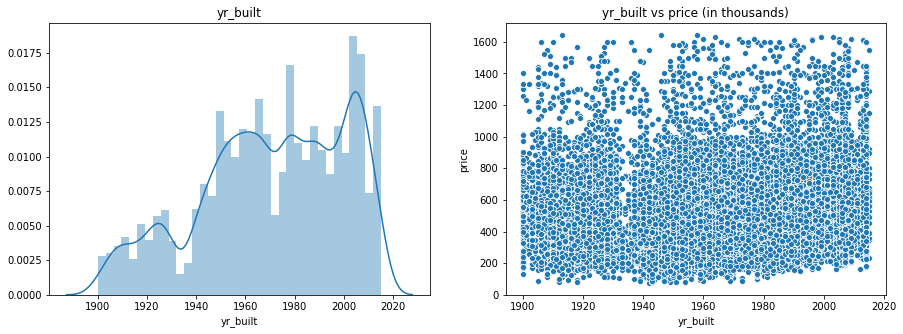

In [54]:
check_column(df['yr_built'], df['price'], nbins = 25)

I want to get rid of zipcode, but I want to check it out first to make sure there's nothing interesting.

---------------------------------------------------------------------------
series dtype is int64

- Unique Values for zipcode


(98020.8, 98040.6]              4226
(98100.0, 98119.8]              4164
(98040.6, 98060.4]              3094
(98000.80099999999, 98020.8]    2661
(98119.8, 98139.6]              1797
(98060.4, 98080.2]              1627
(98139.6, 98159.4]              1116
(98159.4, 98179.2]              1019
(98179.2, 98199.0]               717
(98080.2, 98100.0]               348
Name: zipcode, dtype: int64

n- Null Values 
0

	Describe
count    20769.000000
mean     98078.910877
std         53.580835
min      98001.000000
25%      98033.000000
50%      98070.000000
75%      98118.000000
max      98199.000000
Name: zipcode, dtype: float64


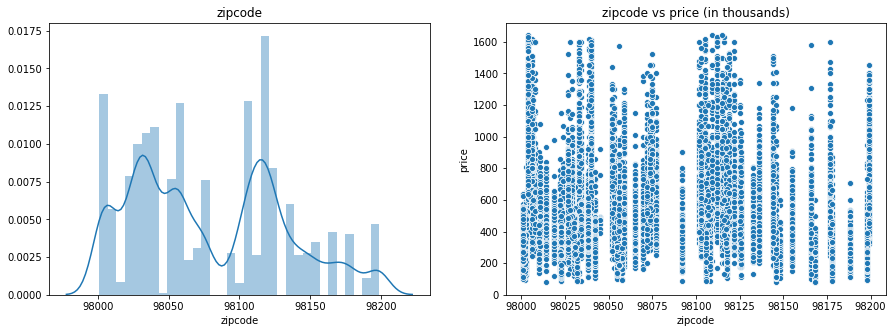

In [55]:
check_column(df['zipcode'], df['price'], nbins = 10)

It's definitely interesting, but I think I'm going to go a different direction with location and use lat and long instead.

## Final Scatters for last check

In [56]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,zipcode,lat,long,sqft_lot15
count,20769.000000,20769.000000,20769.000000,20769.000000,2.076900e+04,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000
mean,502.121643,3.346430,2.072753,2004.668304,1.410738e+04,1.483244,0.003756,3.412393,7.581203,1970.582695,98078.910877,47.559595,-122.220039,12122.358274
std,252.131005,0.888595,0.717335,781.378588,3.779620e+04,0.538648,0.061169,0.651050,1.076595,29.341696,53.580835,0.140078,0.131894,25026.438805
min,78.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,1900.000000,98001.000000,47.159300,-122.519000,651.000000
25%,320.000000,3.000000,1.500000,1410.000000,5.000000e+03,1.000000,0.000000,3.000000,7.000000,1951.000000,98033.000000,47.467000,-122.331000,5040.000000
50%,445.000000,3.000000,2.250000,1890.000000,7.500000e+03,1.000000,0.000000,3.000000,7.000000,1974.000000,98070.000000,47.571500,-122.237000,7520.000000
75%,625.000000,4.000000,2.500000,2490.000000,1.028900e+04,2.000000,0.000000,4.000000,8.000000,1996.000000,98118.000000,47.679600,-122.129000,9858.000000
max,1640.000000,11.000000,7.500000,4540.000000,1.651359e+06,3.500000,1.000000,5.000000,12.000000,2015.000000,98199.000000,47.777600,-121.792000,560617.000000


---------------------------------------------------------------------------
series dtype is int64

- Unique Values for sqft_living


(365.829, 2455.0]    15380
(2455.0, 4540.0]      5389
Name: sqft_living, dtype: int64

n- Null Values 
0

	Describe
count    20769.000000
mean      2004.668304
std        781.378588
min        370.000000
25%       1410.000000
50%       1890.000000
75%       2490.000000
max       4540.000000
Name: sqft_living, dtype: float64
---------------------------------------------------------------------------
series dtype is int64

- Unique Values for grade


(2.99, 7.5]    11140
(7.5, 12.0]     9629
Name: grade, dtype: int64

n- Null Values 
0

	Describe
count    20769.000000
mean         7.581203
std          1.076595
min          3.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         12.000000
Name: grade, dtype: float64
---------------------------------------------------------------------------
series dtype is int64

- Unique Values for bedrooms


(0.989, 6.0]    20724
(6.0, 11.0]        45
Name: bedrooms, dtype: int64

n- Null Values 
0

	Describe
count    20769.000000
mean         3.346430
std          0.888595
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64
---------------------------------------------------------------------------
series dtype is float64

- Unique Values for waterfront


(-0.002, 0.5]    20691
(0.5, 1.0]          78
Name: waterfront, dtype: int64

n- Null Values 
0

	Describe
count    20769.000000
mean         0.003756
std          0.061169
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: waterfront, dtype: float64
---------------------------------------------------------------------------
series dtype is float64

- Unique Values for lat


(47.468, 47.778]    15547
(47.158, 47.468]     5222
Name: lat, dtype: int64

n- Null Values 
0

	Describe
count    20769.000000
mean        47.559595
std          0.140078
min         47.159300
25%         47.467000
50%         47.571500
75%         47.679600
max         47.777600
Name: lat, dtype: float64
---------------------------------------------------------------------------
series dtype is float64

- Unique Values for long


(-122.521, -122.155]    14562
(-122.155, -121.792]     6207
Name: long, dtype: int64

n- Null Values 
0

	Describe
count    20769.000000
mean      -122.220039
std          0.131894
min       -122.519000
25%       -122.331000
50%       -122.237000
75%       -122.129000
max       -121.792000
Name: long, dtype: float64


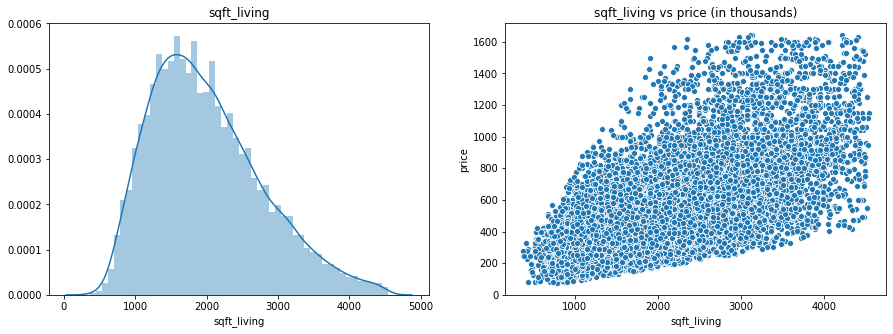

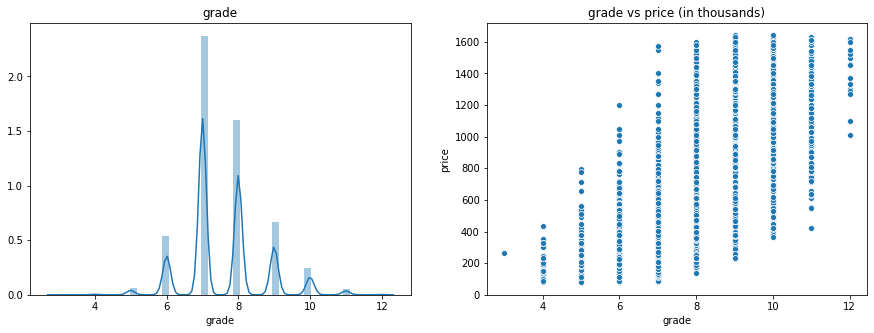

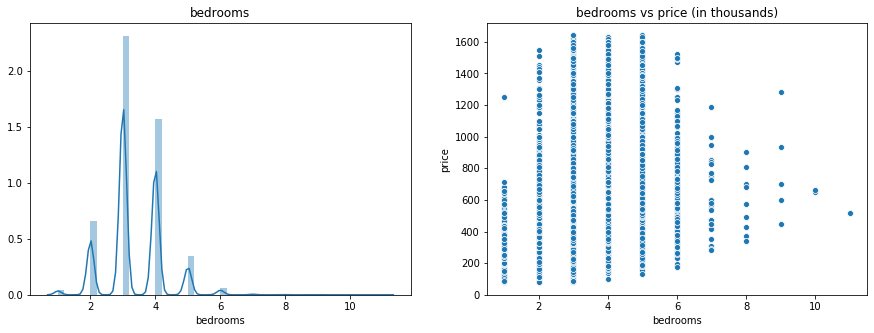

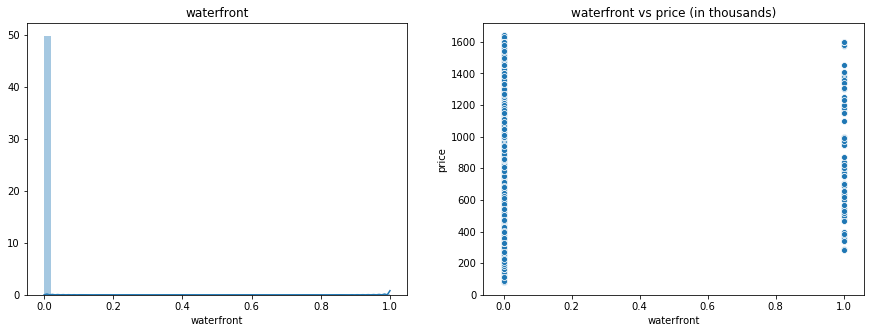

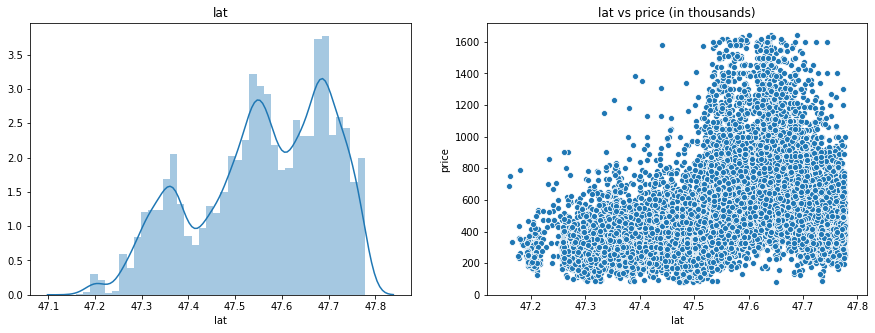

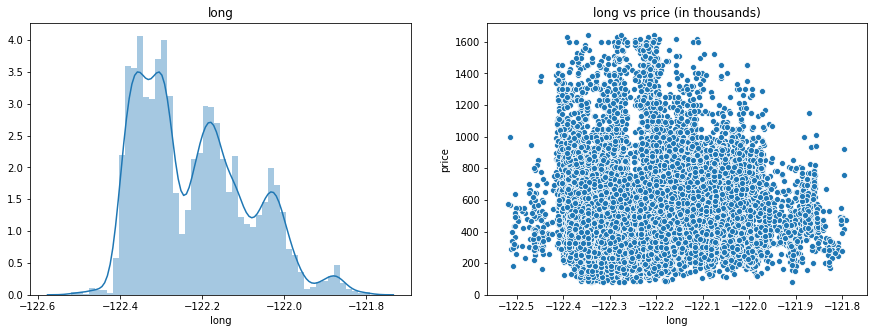

In [57]:
check_column(df['sqft_living'], df['price'], nbins = 2)
check_column(df['grade'], df['price'], nbins = 2)
check_column(df['bedrooms'], df['price'], nbins = 2)
check_column(df['waterfront'], df['price'], nbins = 2)
check_column(df['lat'], df['price'], nbins = 2)
check_column(df['long'], df['price'], nbins = 2)

# MODEL

## 1st Model Attempt

There might be some holes in the work up to this point but I want to get a working model together so I know where to move forward from.

In [58]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

I'll start out with just a few variables to keep it simple and make sure everything is working properly.

In [59]:
it_1_predictors = df[['sqft_living', 'waterfront', 'bedrooms']]
formula = 'price~sqft_living+C(waterfront)+bedrooms'

In [60]:
model_1 = ols(formula = formula, data = df).fit()

In [61]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     5225.
Date:                Fri, 08 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:16:47   Log-Likelihood:            -1.3848e+05
No. Observations:               20769   AIC:                         2.770e+05
Df Residuals:                   20765   BIC:                         2.770e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              156.4222      5.175     30.226      0.000     146.279     166.566
C(waterfront)[T.1.0]   349.2333     21.624     16.150      0.000     306.849     391.618
sqft_living              0.2311      0.002    109.069      0.000       0.227       0.235
bedrooms               -35.5341      1.864    -19.062      0.000     -39.188     -31.880
==============================================================================
Omnibus:                     3477.660   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7527.067
Skew:                           0.988   Prob(JB):                         0.00
Kurtosis:                       5.190   Cond. No.                     3.52e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

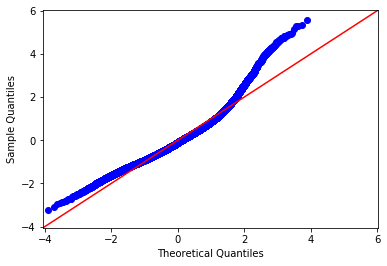

In [62]:
# Putting up a qq plot on the final result to see how it looks.

import scipy.stats as stats

residuals = model_1.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

Does it work?

In [63]:
def predict_value(sqft_living = None, waterfront = None, bedrooms = None):
    if not sqft_living:
        sqft_living = df['sqft_living'].mean()
    if not waterfront:
        waterfront = 0
    if not bedrooms:
        bedrooms = 3
    return (86.2416) + (0.3056*sqft_living) + (	825.3999*waterfront) + (-55.5479*bedrooms)

estimated_price = predict_value(sqft_living = 2000, waterfront = 1, bedrooms = 5)
print(estimated_price)

1245.1019999999999


The above value represents taking a stab at a real-world scenario of estimating the value of a house with ceratin features, in this case: a 2,000 sqft house with 5 bedrooms on the waterfront. Estimated price is $1.25M.

## 2nd Model Attempt
That first one had two problems: The latitude value had not been standardized (which I wound up dropping completely), and possiblly not enough features. Though the R^2 value was higher, the coefficients were screwy, and the real-world estimates were off by, oh, a billion dollars or so.

Trying again with scaling the lat & long values.

In [64]:
# Using min/max scalaing for lat & long values.
lat_minmax = (df['lat'] - min(df['lat'])) / (max(df['lat']) - min(df['lat']))
latmax = df['lat'].max()
latmin = df['lat'].min()
long_minmax = (df['long'] - min(df['long'])) / (max(df['long']) - min(df['long']))
longmax = df['long'].max()
longmin = df['long'].min()

In [65]:
age = pd.DataFrame(2019 - df['yr_built'])
age.columns = ['age']
it_2_predictors = df[['sqft_living', 'waterfront', 'bedrooms']]
it_2_predictors = pd.concat([it_1_predictors, lat_minmax, long_minmax, df['price']], axis = 1)
formula = 'price~sqft_living+C(waterfront)+bedrooms+lat_minmax+long_minmax'

In [66]:
model_2 = ols(formula = formula, data = it_2_predictors).fit()

In [67]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     5630.
Date:                Fri, 08 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:16:47   Log-Likelihood:            -1.3542e+05
No. Observations:               20769   AIC:                         2.709e+05
Df Residuals:                   20763   BIC:                         2.709e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -72.6475      6.085    -11.938      0.000     -84.576     -60.719
C(waterfront)[T.1.0]   380.7472     18.720     20.339      0.000     344.054     417.440
sqft_living              0.2312      0.002    121.784      0.000       0.227       0.235
bedrooms               -29.2682      1.612    -18.152      0.000     -32.429     -26.108
lat_minmax             400.2762      5.105     78.416      0.000     390.271     410.281
long_minmax           -124.8105      6.659    -18.743      0.000    -137.863    -111.758
==============================================================================
Omnibus:                     4761.216   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15448.178
Skew:                           1.160   Prob(JB):                         0.00
Kurtosis:                       6.531   Cond. No.                     3.54e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

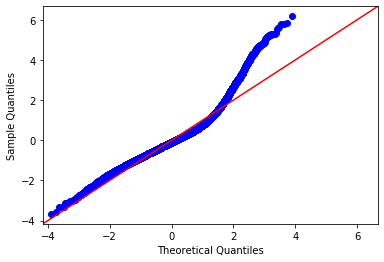

In [68]:
# Putting up a qq plot on the final result to see how it looks.

import scipy.stats as stats

residuals = model_2.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [69]:
def predict_value(sqft_living = None, waterfront = None, bedrooms = None, lat = None):
    if not sqft_living:
        sqft_living = df['sqft_living'].mean()
    if not waterfront:
        waterfront = 0
    if not lat:
        lat = df['lat'].mean()
    else:
        lat = (lat - df.lat.min()) / (df.lat.max() - df.lat.min())
    if not bedrooms:
        bedrooms = 3
    return ((-201.9622) + (0.2964*sqft_living) + (851.1191*waterfront) +
            (-49.8772*bedrooms) + (442.7264*lat))

estimated_price = round(predict_value(sqft_living = 3000, waterfront = 0, bedrooms = 5, lat = 47.5), 2)
print(estimated_price)

681.81


## 3rd Model Attempt

### Attempt A:

This was the original 3rd model. As it was the stroongest, I kept it intact to perform further modification below.

Going to play with adding and maybe changing some of the variables

In [70]:
data_3 = pd.DataFrame([])
data_3['price'] = df['price']
data_3['sqft_living'] = df['sqft_living']
data_3['grade'] = df['price']
data_3['bathrooms'] = df['bathrooms']
data_3['bedrooms'] = df['bedrooms']
data_3['lat'] = lat_minmax
data_3['long'] = long_minmax
data_3['waterfront'] = df['waterfront']
data_3['grade'] = df['grade']
data_3['age'] = 2019 - df['yr_built']
data_3['zipcode'] = df['zipcode']

In [140]:
formula = 'price~grade+C(waterfront)+lat+long+age+sqft_living+C(zipcode)'

In [141]:
model_3 = ols(formula = formula, data = data_3).fit()

In [142]:
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     1156.
Date:                Fri, 08 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:26:58   Log-Likelihood:            -1.2722e+05
No. Observations:               20769   AIC:                         2.546e+05
Df Residuals:                   20693   BIC:                         2.552e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -554.6339     16.304    -34.018      0.000    -586.592    -522.676
C(waterfront)[T.1.0]   410.1240     12.972     31.615      0.000     384.697     435.551
C(zipcode)[T.98002]     17.1297     10.090      1.698      0.090      -2.647      36.906
C(zipcode)[T.98003]     -9.6173      9.010     -1.067      0.286     -27.278       8.044
C(zipcode)[T.98004]    570.0877     17.173     33.197      0.000     536.428     603.748
C(zipcode)[T.98005]    282.1245     18.153     15.542      0.000     246.544     317.705
C(zipcode)[T.98006]    251.9703     15.163     16.617      0.000     222.249     281.692
C(zipcode)[T.98007]    203.2716     18.809     10.807      0.000     166.405     240.138
C(zipcode)[T.98008]    206.0766     18.204     11.321      0.000     170.396     241.757
C(zipcode)[T.98010]     93.9851     16.969      5.539      0.000      60.725     127.245
C(zipcode)[T.98011]     77.1834     22.900      3.370      0.001      32.297     122.070
C(zipcode)[T.98014]     89.2047     26.299      3.392      0.001      37.657     140.752
C(zipcode)[T.98019]     47.4719     26.470      1.793      0.073      -4.412      99.356
C(zipcode)[T.98022]     47.9541     14.862      3.227      0.001      18.823      77.085
C(zipcode)[T.98023]    -27.4499      8.598     -3.193      0.001     -44.302     -10.598
C(zipcode)[T.98024]    127.1201     24.598      5.168      0.000      78.906     175.334
C(zipcode)[T.98027]    152.7279     16.377      9.326      0.000     120.628     184.827
C(zipcode)[T.98028]     73.2397     22.076      3.318      0.001      29.969     116.510
C(zipcode)[T.98029]    178.1113     18.774      9.487      0.000     141.312     214.911
C(zipcode)[T.98030]     -5.9568     10.135     -0.588      0.557     -25.823      13.909
C(zipcode)[T.98031]     -1.5426     10.606     -0.145      0.884     -22.331      19.246
C(zipcode)[T.98032]    -18.0072     11.911     -1.512      0.131     -41.354       5.339
C(zipcode)[T.98033]    307.5991     19.263     15.968      0.000     269.841     345.357
C(zipcode)[T.98034]    137.1134     20.518      6.683      0.000      96.897     177.330
C(zipcode)[T.98038]     33.9241     12.915      2.627      0.009       8.609      59.239
C(zipcode)[T.98039]    769.7202     30.509     25.230      0.000     709.921     829.520
C(zipcode)[T.98040]    461.7667     14.984     30.816      0.000     432.396     491.137
C(zipcode)[T.98042]      7.4885     10.413      0.719      0.472     -12.922      27.899
C(zipcode)[T.98045]     48.3032     37.063      1.303      0.192     -24.343     120.949
C(zipcode)[T.98052]    192.7473     20.050      9.613      0.000     153.448     232.047
C(zipcode)[T.98053]    192.1527     22.252      8.635      0.000     148.536     235.769
C(zipcode)[T.98055]     19.3460     11.764      1.644    

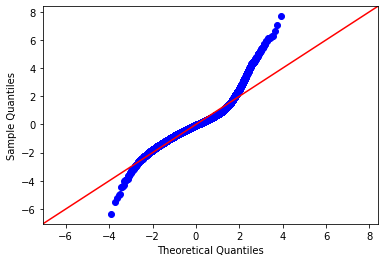

In [74]:
# Putting up a qq plot on the final result to see how it looks.

import scipy.stats as stats

residuals = model_3.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

### Attempt B:

In my second interation of the 3rd model, I decided to work with scaling a bit more to see if it would change the output.

In [75]:
# scaling all the values
def scale_it(feature):
    return(feature - min(feature)) / (max(feature) - min(feature))

In [76]:
def standardize_it(feature):
    return (feature - np.mean(feature)) / np.sqrt(np.var(feature))

In [77]:
def normalize_it(feature):
    return (feature - np.mean(feature)) / (max(feature) - min(feature))

In [78]:
# Applying log transformations
data_3b = pd.DataFrame([])
data_3b['lat'] = df.lat
data_3b['long'] = abs(df.long)
data_3b['price'] = df.price
data_3b['sqft_living'] = df.sqft_living
data_3b['grade'] = df.grade
data_3b['age'] = age.age

for feat in data_3b:
    data_3b[feat] = data_3b[feat].map(lambda x: np.log(x))
    
data_3b['long'] = data_3b.long - data_3b.long * 2

In [79]:
data_3b.head()

,lat,long,price,sqft_living,grade,age
0,3.860965,-4.806125,5.402227,7.073270,1.945910,4.158883
1,3.865372,-4.806632,6.287859,7.851661,1.945910,4.219508
2,3.865726,-4.805929,5.192957,6.646391,1.791759,4.454347
3,3.861168,-4.807237,6.403574,7.580700,1.945910,3.988984
4,3.863186,-4.804390,6.234411,7.426549,2.079442,3.465736


In [80]:
# data_3b['price'] = price_scaled
# data_3b['price'] = df.price
data_3b['waterfront'] = df.waterfront

In [81]:
data_3b.head()

,lat,long,price,sqft_living,grade,age,waterfront
0,3.860965,-4.806125,5.402227,7.073270,1.945910,4.158883,0.0
1,3.865372,-4.806632,6.287859,7.851661,1.945910,4.219508,0.0
2,3.865726,-4.805929,5.192957,6.646391,1.791759,4.454347,0.0
3,3.861168,-4.807237,6.403574,7.580700,1.945910,3.988984,0.0
4,3.863186,-4.804390,6.234411,7.426549,2.079442,3.465736,0.0


I'll be commenting out some of the below at various times as I try different transformations on various features.

In [82]:
# lat_scaled = scale_it(df.lat)
# long_scaled = scale_it(df.long)
# sqft_living_scaled = scale_it(df.sqft_living)
# grade_scaled = scale_it(df.grade)
# age_scaled = scale_it(df.age)
# price_scaled = scale_it(df.price)

In [83]:
# lat_scaled = normalize_it(data_3b.lat)
# long_scaled = standardize_it(data_3b.long)
# sqft_living_scaled = standardize_it(data_3b.sqft_living)
# price_scaled = standardize_it(data_3b.price)
# grade_scaled = standardize_it(data_3b.grade)
# age_scaled = standardize_it(data_3b.age)
# price_scaled = standardize_it(data_3b.price)

In [84]:
lat_scaled = normalize_it(df.lat)
long_scaled = normalize_it(df.long)
sqft_living_scaled = normalize_it(df.sqft_living)
# price_scaled = normalize_it(data_3b.price)
grade_scaled = normalize_it(df.grade)
age_scaled = normalize_it(data_3b.age)
price_scaled = normalize_it(df.price)

In [85]:
data_3b['lat'] = lat_scaled
data_3b['long'] = long_scaled
# data_3b['price'] = price_scaled
data_3b['price'] = df.price
data_3b['sqft_living'] = sqft_living_scaled
data_3b['lat'] = lat_minmax
data_3b['long'] = long_minmax
data_3b['waterfront'] = df['waterfront']
data_3b['grade'] = grade_scaled

In [86]:
data_3b.head()

,lat,long,price,sqft_living,grade,age,waterfront
0,0.569141,0.360385,221.9,-0.197762,-0.064578,4.158883,0.0
1,0.908459,0.275103,538.0,0.135571,-0.064578,4.219508,0.0
2,0.935792,0.393398,180.0,-0.296084,-0.175689,4.454347,0.0
3,0.584668,0.173315,604.0,-0.010712,-0.064578,3.988984,0.0
4,0.739932,0.651994,510.0,-0.077858,0.046533,3.465736,0.0


In [87]:
formula = 'price~lat+C(waterfront)+grade+sqft_living+long+age'

In [88]:
model_3b = ols(formula = formula, data = data_3b).fit()

In [89]:
model_3b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     6331.
Date:                Fri, 08 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:16:48   Log-Likelihood:            -1.3352e+05
No. Observations:               20769   AIC:                         2.671e+05
Df Residuals:                   20762   BIC:                         2.671e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              103.5186      7.402     13.985      0.000      89.010     118.027
C(waterfront)[T.1.0]   374.6817     17.067     21.954      0.000     341.230     408.133
lat                    348.1337      4.736     73.508      0.000     338.851     357.417
grade                  902.9436     13.585     66.466      0.000     876.316     929.571
sqft_living            531.2849      8.184     64.915      0.000     515.243     547.327
long                   -80.7411      6.295    -12.825      0.000     -93.081     -68.402
age                     56.3965      1.588     35.522      0.000      53.285      59.508
==============================================================================
Omnibus:                     4702.389   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15384.868
Skew:                           1.143   Prob(JB):                         0.00
Kurtosis:                       6.543   Cond. No.                         64.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

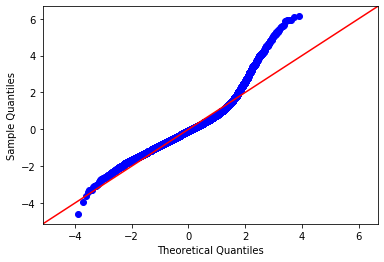

In [90]:
# Putting up a qq plot on the final result to see how it looks.

import scipy.stats as stats

residuals = model_3b.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

It looks like log functions, min/max scaling, standardization, and normalization only had negative effects on the ultimiate figures.

## 4th Model Attempt

Now that I'm done blindly feeling around in the dark, I'll actually try some
recursive feature elimination and see how that goes.

In [91]:
rfe_predictors = df[['sqft_living', 'waterfront', 'bedrooms', 'grade',
                     'bathrooms']]
rfe_predictors = pd.concat([rfe_predictors, lat_minmax, long_minmax, age], 
                           axis = 1)

In [92]:
rfe_predictors.head()

,sqft_living,waterfront,bedrooms,grade,bathrooms,lat,long,age
0,1180,0.0,3,7,1.00,0.569141,0.360385,64
1,2570,0.0,3,7,2.25,0.908459,0.275103,68
2,770,0.0,2,6,1.00,0.935792,0.393398,86
3,1960,0.0,4,7,3.00,0.584668,0.173315,54
4,1680,0.0,3,8,2.00,0.739932,0.651994,32


In [93]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=5)
selector = selector.fit(rfe_predictors, df['price'])

In [94]:
selector.support_ 

array([False,  True, False,  True,  True,  True,  True, False])

In [95]:
selector.ranking_

array([4, 1, 2, 1, 1, 1, 1, 3])

In [96]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[419.54064611 127.04276865  50.89666619 369.64389196 -88.44324702]
-771.0291364734657


In [97]:
formula = 'price~grade+bathrooms+lat+long+waterfront'

In [98]:
model_4 = ols(formula = formula, data = data_3).fit()

In [99]:
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     5299.
Date:                Fri, 08 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:16:49   Log-Likelihood:            -1.3578e+05
No. Observations:               20769   AIC:                         2.716e+05
Df Residuals:                   20763   BIC:                         2.716e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -771.0291      8.970    -85.955      0.000    -788.611    -753.447
grade        127.0428      1.397     90.921      0.000     124.304     129.782
bathrooms     50.8967      2.091     24.346      0.000      46.799      54.994
lat          369.6439      5.227     70.714      0.000     359.398     379.890
long         -88.4432      6.735    -13.132      0.000    -101.645     -75.242
waterfront   419.5406     19.011     22.068      0.000     382.277     456.805
==============================================================================
Omnibus:                     5133.041   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15683.566
Skew:                           1.273   Prob(JB):                         0.00
Kurtosis:                       6.412   Cond. No.                         132.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

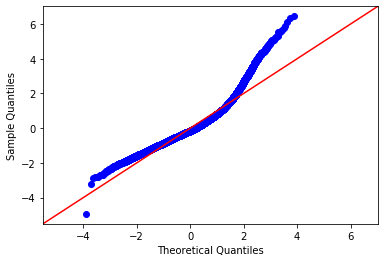

In [100]:
# Putting up a qq plot on the final result to see how it looks.

import scipy.stats as stats

residuals = model_4.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

Going backward on the R^2 number, now. Throwing in the towel.

## Model Testing

Finally, a little train-test split to see how things shook out. I'll focus on our best model: Model #3.

In [101]:
from sklearn.model_selection import train_test_split

X = df[['sqft_living', 'grade', 'waterfront']]
X = pd.concat([X, lat_minmax, long_minmax], axis = 1)
Y = df['price']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [103]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

14538 6231 14538 6231


In [104]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [105]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 23799.877848680513
Test Mean Squarred Error: 23909.6804097783


Good enough for me. Calling it a day.

# iNTERPRET

Below is a function that takes in housing attributes and predicts the value for Kings County homes.

Because model 3 has our highest R^2 value, I'm using its values to create this estimate tool.

In [106]:
def predict_value(sqft_living = None, grade = None, lat = None, long = None, 
                  waterfront = None, age = None, bedrooms = None,
                  bathrooms = None):
    lat = (lat - latmin) / (latmax - latmin)
    long = (long - longmin) / (longmax - longmin)
    return round(((-0.2552) + (0.3401*sqft_living) +
            (0.2399*waterfront) + (0.5781*grade) +
            (0.2229*lat) + (-0.0517*long) + (0.0361*age)), 2)

Below is a means of entering house data in order to retrive a predicted value.

In [107]:
prediction = input("Enter prediction? Y/N ")

if prediction == 'Y' or prediction == 'y':
    sqft_input = input('Square Feet: ')
    water_input = input('Waterfront? Y/N ')
    grade_input = input('Grade: ')
    lat_input = input('Latitude: ')
    long_input = input('Longitude: ')
    age_input = input('Age (in years): ')
    if water_input == 'Y' or water_input == 'y':
        water_input = 1
    else:
        water_input = 0
    estimated_price = predict_value(sqft_living = float(sqft_input),
                                   waterfront = water_input, grade =
                                   float(grade_input), lat = float(lat_input), 
                                   long = float(long_input), age = float(age_input))
    if estimated_price < 1000:
        estimated_price = int(estimated_price)
        estimated_price = '$' + str(estimated_price) + 'k'
    else:
        estimated_price = round(estimated_price / 1000, 1)
        estimated_price = '$' + str(estimated_price) + 'M'
    print(estimated_price)
else:
    print('OK then')
    

Enter prediction? Y/N N
OK then


Below I'm adding a couple of columns to demonstrate how closely the model can 
predict the existing data set.

In [108]:
df = pd.concat([df, age], axis = 1)

df['estimated_price'] = predict_value(df.sqft_living, df.grade, df.lat, 
                                      df.long, df.waterfront, df.age)
df['estimated_percent'] = (df.price - df.estimated_price) / df.estimated_price

In [109]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_basement,yr_built,zipcode,lat,long,sqft_lot15,age,estimated_price,estimated_percent
0,10/13/2014,221.9,3,1.00,1180,5650,1.0,0.0,3,7,0.0,1955,98178,47.5112,-122.257,5650,64,407.53,-0.455500
1,12/9/2014,538.0,3,2.25,2570,7242,2.0,0.0,3,7,400.0,1951,98125,47.7210,-122.319,7639,68,880.49,-0.388977
2,2/25/2015,180.0,2,1.00,770,10000,1.0,0.0,3,6,0.0,1933,98028,47.7379,-122.233,8062,86,268.38,-0.329309
3,12/9/2014,604.0,4,3.00,1960,5000,1.0,0.0,5,7,910.0,1965,98136,47.5208,-122.393,5000,54,672.46,-0.101805
4,2/18/2015,510.0,3,2.00,1680,8080,1.0,0.0,3,8,0.0,1987,98074,47.6168,-122.045,7503,32,577.02,-0.116148


In [110]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,zipcode,lat,long,sqft_lot15,age,estimated_price,estimated_percent
count,20769.000000,20769.000000,20769.000000,20769.000000,2.076900e+04,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000
mean,502.121643,3.346430,2.072753,2004.668304,1.410738e+04,1.483244,0.003756,3.412393,7.581203,1970.582695,98078.910877,47.559595,-122.220039,12122.358274,48.417305,687.787042,-0.243548
std,252.131005,0.888595,0.717335,781.378588,3.779620e+04,0.538648,0.061169,0.651050,1.076595,29.341696,53.580835,0.140078,0.131894,25026.438805,29.341696,265.836471,0.301996
min,78.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,1900.000000,98001.000000,47.159300,-122.519000,651.000000,4.000000,132.120000,-0.744982
25%,320.000000,3.000000,1.500000,1410.000000,5.000000e+03,1.000000,0.000000,3.000000,7.000000,1951.000000,98033.000000,47.467000,-122.331000,5040.000000,23.000000,485.980000,-0.472431
50%,445.000000,3.000000,2.250000,1890.000000,7.500000e+03,1.000000,0.000000,3.000000,7.000000,1974.000000,98070.000000,47.571500,-122.237000,7520.000000,45.000000,647.930000,-0.291313
75%,625.000000,4.000000,2.500000,2490.000000,1.028900e+04,2.000000,0.000000,4.000000,8.000000,1996.000000,98118.000000,47.679600,-122.129000,9858.000000,68.000000,851.790000,-0.083806
max,1640.000000,11.000000,7.500000,4540.000000,1.651359e+06,3.500000,1.000000,5.000000,12.000000,2015.000000,98199.000000,47.777600,-121.792000,560617.000000,119.000000,1551.030000,1.338626


Oddly enough, despite having a slightly lower R^2 value, model 3b did in fact turn up better real-world numbers when applied to the data set. Of course, how that relates to future prediction is beyond me to say at this time!


# CONCLUSIONS & RECOMMENDATIONS

Don't move to Seattle. The homes are expensive and the weather is crummy.

It may not be surprising that homes on the waterfront are more valuable than those that aren't. But what our latitude and longitude features also demonstrate that there are additional location factors that can have a major impact on home value.

Especially when building on expensive land, in order to achieve the best results, there are several factors to keep in mind in order to maximize the usage of that real estate.

Along with overall square feet of living space, the grade based on the Kings County grading system affects the house in a very linear way. An eye toward improving this score should be maintained at all times by builders, buyers, and renovators.

As to the square footage, it can maximized at a high level for the best investment returns. But how that space is used is just as important.

After five or six bedrooms, there are diminishing returns to how much they add to the value of a home, and it seems they might even begin to detract. What this might suggest is that with too many bedrooms, the space begins to feel closed in, and does not provide the value of a more open floorplan. Large, open spaces might create the feeling of a more valuable home, raising the price at which a buyer might be willing to pay. 

For the builder or re-builder, this pays off in two ways: The home's value increases due to better use of space, and there is a lower cost associated with decreased labor and materians for fewer rooms, factoring in extra wall materials, electrical, etc. Even more so for bathrooms, which require plumbing and fixtures in addition.


# Supplemental materials for presentation

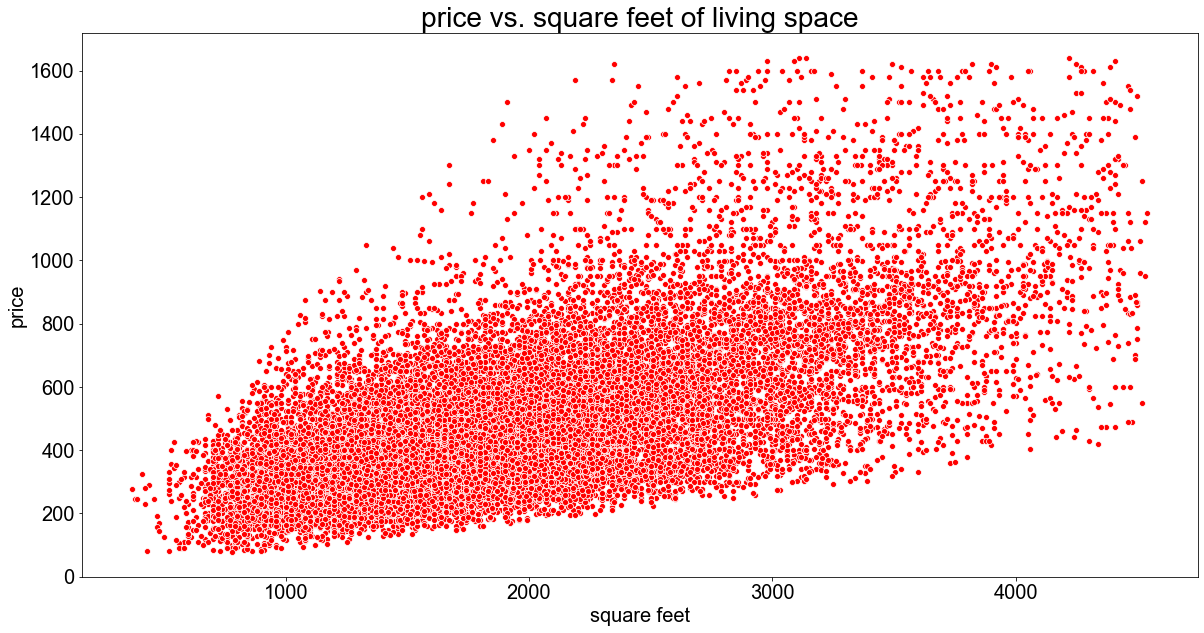

In [111]:
plt.figure(figsize = (20,10))
sns.scatterplot(df.sqft_living, df.price, color = 'red')
plt.xlabel('square feet', fontsize = 20, color = 'black')
plt.ylabel('price', fontsize = 20, color = 'black')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('price vs. square feet of living space', fontsize = 28, color = 'black')
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'silver'})
plt.show()

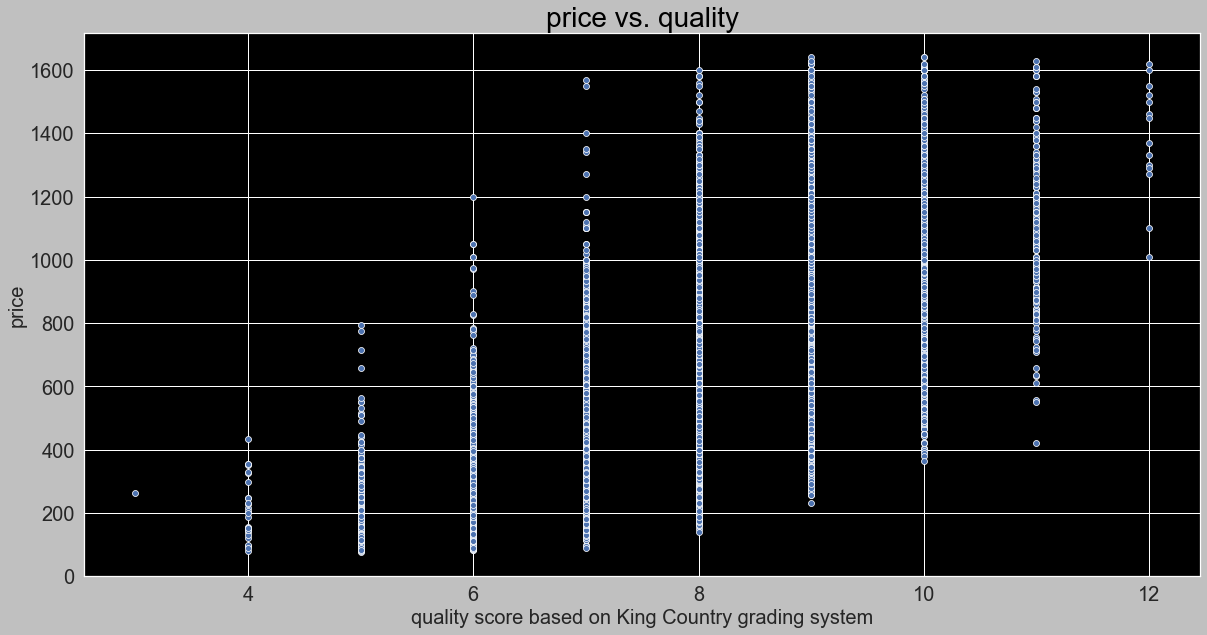

In [112]:
plt.figure(figsize = (20,10))
sns.scatterplot(df.grade, df.price)
plt.xlabel('quality score based on King Country grading system', fontsize = 20)
plt.ylabel('price', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('price vs. quality', fontsize = 28, color = 'black')
sns.set(rc={'axes.facecolor': 'white', 'figure.facecolor': 'white'})
plt.show()